# Basic Classifiser for Specific AV

Create a basic classifier for specific vendors, meaning it trains and validates the samples based on a single vendor.

In [1]:
import pandas as pd
import numpy as np
import lib.data_loading as jcfg_data_loading
import lib.helpers as jcfg_helpers
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


test_size = 0.50

# Use the original samples to remove all but the last submission of duplicated samples
samples = pd.read_csv('data/mined_data/pe32_samples.csv')
samples = jcfg_data_loading.set_pd_datetime_index(samples)
samples.drop_duplicates(subset='md5', inplace=True, keep='last')

## Microsoft Classifier

**Ignoring temporal consistency**, train and test a classifier for microsoft only samples

In [2]:
# Load the needed CSVs
static_imports = pd.read_csv('data/mined_data/pe32_static_imports.csv', dtype=str)
static_imports = static_imports.set_index('link')

microsoft_samples = pd.read_csv('data/mined_data/microsoft_classification.csv', dtype=str)
microsoft_samples = microsoft_samples.set_index('link')

# Join the microsoft samples with the imports
dataset = microsoft_samples.join(static_imports).dropna(subset=['imports'])
dataset.drop(['info', 'variant', 'family', 'platform'], axis=1, inplace=True)
# Remove dups
dataset = dataset[dataset.index.isin(samples.link)]

dataset.type.fillna(value=0, inplace=True)


# Filter types of malware
dataset = dataset[(dataset.type == 'trojan') | (dataset.type == 0)]


dataset.type = dataset.type.replace(to_replace=None, value=1, regex=r'.+').astype(int)
dataset.rename(columns={'type': 'malware'}, inplace=True)

print('Malware in dataset: {}'.format(len(dataset[dataset.malware == 1])))
print('Goodware in dataset: {}'.format(len(dataset[dataset.malware == 0])))

Malware in dataset: 15926
Goodware in dataset: 154556


In [3]:
# How imports vary on malware/goodware
microsoft_malware = dataset[dataset.malware == 1]
microsoft_goodware = dataset[dataset.malware == 0]

mcm_count = microsoft_malware.imports.apply(lambda x: len(x.split(';')))
mcg_count = microsoft_goodware.imports.apply(lambda x: len(x.split(';')))

print('Statistics on malware imports:')
display(mcm_count.describe())
print('\nStatistics on goodware imports:')
display(mcg_count.describe())

Statistics on malware imports:


count    15926.000000
mean        88.010863
std        117.295228
min          1.000000
25%         11.000000
50%         56.000000
75%        114.000000
max       3036.000000
Name: imports, dtype: float64


Statistics on goodware imports:


count    154556.000000
mean        124.116689
std         176.287262
min           1.000000
25%          19.000000
50%          83.000000
75%         154.000000
max       13325.000000
Name: imports, dtype: float64

CC:	0.9193
DR:	0.2702
FP:	0.3261
FN:	0.0711

Malware stats:


count    7.995000e+03
mean     3.386372e-01
std      3.228336e-01
min      5.765555e-12
25%      6.123047e-02
50%      2.286145e-01
75%      5.504453e-01
max      1.000000e+00
dtype: float64


Goodware stats:


count    77246.000000
mean         0.932180
std          0.111091
min          0.000002
25%          0.936263
50%          0.965116
75%          0.996058
max          1.000000
dtype: float64

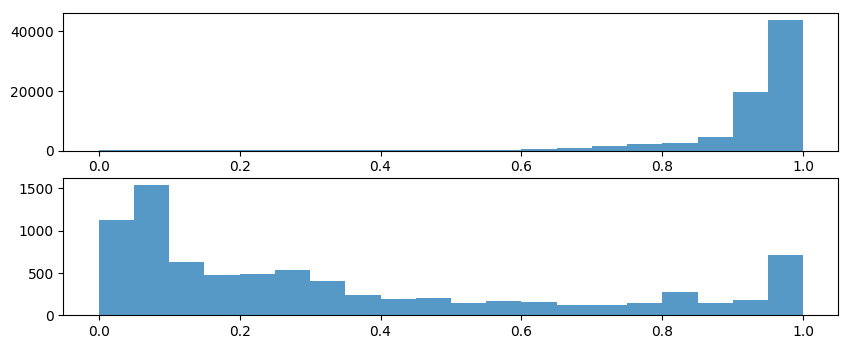

CPU times: user 1min 4s, sys: 1 s, total: 1min 5s
Wall time: 1min 4s


In [4]:
%%time
# Raw LR, use all imports, dataset balanced as is (more goodware than malware)
# Split into train and test (this also shuffles the data)
(train, test) = train_test_split(dataset, test_size=test_size)

# Generate the count vectorizer
cv_token_pattern = u'[^;]+'
cv = CountVectorizer(token_pattern=cv_token_pattern)
train_X = cv.fit_transform(train.imports)
train_Y = train.malware
test_X = cv.transform(test.imports)
test_Y = test.malware

# Logistic Regression training
lr = LogisticRegression().fit(train_X, train_Y)

score = confusion_matrix(test_Y, lr.predict(test_X))
fp_rate, fn_rate, cc_rate, det_rate = jcfg_helpers.calc_ratios(score)
print('CC:\t{:.4f}'.format(cc_rate))
print('DR:\t{:.4f}'.format(det_rate))
print('FP:\t{:.4f}'.format(fp_rate))
print('FN:\t{:.4f}'.format(fn_rate))

malware_only = lr.predict_proba(test_X[np.where(test_Y == 1)])
goodware_only = lr.predict_proba(test_X[np.where(test_Y == 0)])
print('\nMalware stats:')
display(pd.Series(malware_only[:,1]).describe())
print('\nGoodware stats:')
display(pd.Series(goodware_only[:,0]).describe())

plt.figure(figsize=(10, 4), dpi=100)
plt.subplot(211)
plt.hist(goodware_only[:,0], bins=20, alpha=0.75)
plt.subplot(212)
plt.hist(malware_only[:,1], bins=20, alpha=0.75)
plt.show()

Malware in dataset: 15926
Goodware in dataset: 15926
CC:	0.7444
DR:	0.7099
FP:	0.2372
FN:	0.2715

Malware stats:


count    7.967000e+03
mean     6.887968e-01
std      2.804966e-01
min      5.566813e-09
25%      4.280878e-01
50%      7.799776e-01
75%      9.416667e-01
max      1.000000e+00
dtype: float64


Goodware stats:


count    7.959000e+03
mean     6.872679e-01
std      2.776652e-01
min      6.305179e-11
25%      5.529609e-01
50%      7.357631e-01
75%      9.524787e-01
max      1.000000e+00
dtype: float64

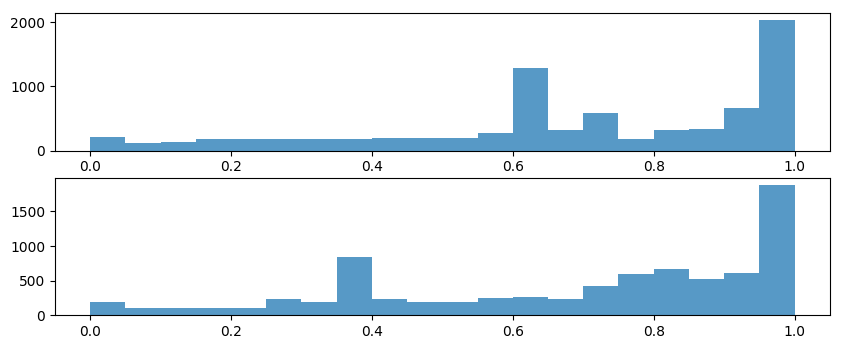

CPU times: user 14.6 s, sys: 377 ms, total: 15 s
Wall time: 14.5 s


In [5]:
%%time
# Use all imports, but balance the datasets
malware_count = len(dataset[dataset.malware == 1])
goodware_count = len(dataset[dataset.malware == 0])

limiting = min(malware_count, goodware_count)
malware = dataset[dataset.malware == 1].sample(n=limiting)
goodware = dataset[dataset.malware == 0].sample(n=limiting)

# Recreate the dataset, now balanced
dataset2 = pd.concat([malware, goodware])

print('Malware in dataset: {}'.format(len(dataset2[dataset2.malware == 1])))
print('Goodware in dataset: {}'.format(len(dataset2[dataset2.malware == 0])))

# Split into train and test (this also shuffles the data)
(train, test) = train_test_split(dataset2, test_size=test_size)

# Generate the count vectorizer
cv_token_pattern = u'[^;]+'
cv = CountVectorizer(token_pattern=cv_token_pattern)
train_X = cv.fit_transform(train.imports)
train_Y = train.malware
test_X = cv.transform(test.imports)
test_Y = test.malware

# Logistic Regression training
lr = LogisticRegression().fit(train_X, train_Y)

score = confusion_matrix(test_Y, lr.predict(test_X))
fp_rate, fn_rate, cc_rate, det_rate = jcfg_helpers.calc_ratios(score)
print('CC:\t{:.4f}'.format(cc_rate))
print('DR:\t{:.4f}'.format(det_rate))
print('FP:\t{:.4f}'.format(fp_rate))
print('FN:\t{:.4f}'.format(fn_rate))

malware_only = lr.predict_proba(test_X[np.where(test_Y == 1)])
goodware_only = lr.predict_proba(test_X[np.where(test_Y == 0)])
print('\nMalware stats:')
display(pd.Series(malware_only[:,1]).describe())
print('\nGoodware stats:')
display(pd.Series(goodware_only[:,0]).describe())

plt.figure(figsize=(10, 4), dpi=100)
plt.subplot(211)
plt.hist(goodware_only[:,0], bins=20, alpha=0.75)
plt.subplot(212)
plt.hist(malware_only[:,1], bins=20, alpha=0.75)
plt.show()

Malware in dataset: 15926
Goodware in dataset: 7963
CC:	0.7627
DR:	0.8844
FP:	0.2152
FN:	0.3027

Malware stats:


count    7917.000000
mean        0.788972
std         0.231006
min         0.000108
25%         0.624393
50%         0.880369
75%         0.973425
max         1.000000
dtype: float64


Goodware stats:


count    4.028000e+03
mean     5.678821e-01
std      3.251170e-01
min      4.286438e-11
25%      3.349494e-01
50%      5.558842e-01
75%      9.104774e-01
max      1.000000e+00
dtype: float64

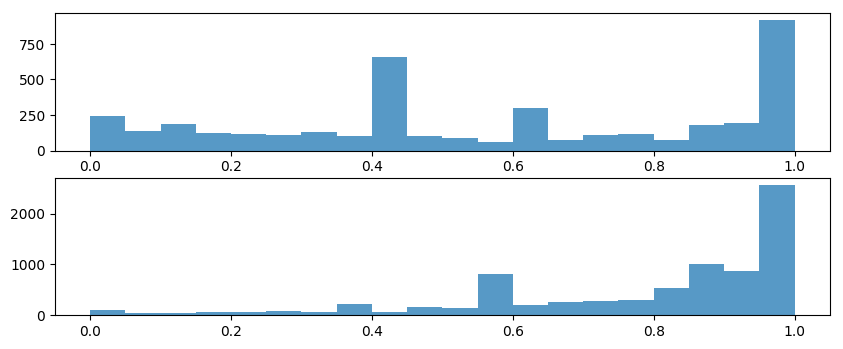

CPU times: user 5.38 s, sys: 303 ms, total: 5.68 s
Wall time: 5.33 s


In [6]:
%%time
# Use all imports, but use more malware for training (more goodware version is default)
malware_count = len(dataset[dataset.malware == 1])
goodware_count = len(dataset[dataset.malware == 0])

limiting = min(malware_count, goodware_count)
malware = dataset[dataset.malware == 1].sample(n=limiting)
# Use 50% less goodware
goodware = dataset[dataset.malware == 0].sample(n=int(limiting * 0.5))

# Recreate the dataset, now balanced
dataset3 = pd.concat([malware, goodware])

print('Malware in dataset: {}'.format(len(dataset3[dataset3.malware == 1])))
print('Goodware in dataset: {}'.format(len(dataset3[dataset3.malware == 0])))

# Split into train and test (this also shuffles the data)
(train, test) = train_test_split(dataset3, test_size=test_size)

# Generate the count vectorizer
cv_token_pattern = u'[^;]+'
cv = CountVectorizer(token_pattern=cv_token_pattern)
train_X = cv.fit_transform(train.imports)
train_Y = train.malware
test_X = cv.transform(test.imports)
test_Y = test.malware

# Logistic Regression training
lr = LogisticRegression().fit(train_X, train_Y)

score = confusion_matrix(test_Y, lr.predict(test_X))
fp_rate, fn_rate, cc_rate, det_rate = jcfg_helpers.calc_ratios(score)
print('CC:\t{:.4f}'.format(cc_rate))
print('DR:\t{:.4f}'.format(det_rate))
print('FP:\t{:.4f}'.format(fp_rate))
print('FN:\t{:.4f}'.format(fn_rate))

malware_only = lr.predict_proba(test_X[np.where(test_Y == 1)])
goodware_only = lr.predict_proba(test_X[np.where(test_Y == 0)])
print('\nMalware stats:')
display(pd.Series(malware_only[:,1]).describe())
print('\nGoodware stats:')
display(pd.Series(goodware_only[:,0]).describe())

plt.figure(figsize=(10, 4), dpi=100)
plt.subplot(211)
plt.hist(goodware_only[:,0], bins=20, alpha=0.75)
plt.subplot(212)
plt.hist(malware_only[:,1], bins=20, alpha=0.75)
plt.show()

Malware in dataset: 13443
Goodware in dataset: 116125
CC:	0.9137
DR:	0.3259
FP:	0.3456
FN:	0.0724

Malware stats:


count    6.607000e+03
mean     3.912913e-01
std      3.298923e-01
min      4.738641e-07
25%      1.036558e-01
50%      2.823920e-01
75%      6.661971e-01
max      1.000000e+00
dtype: float64


Goodware stats:


count    5.817700e+04
mean     9.263193e-01
std      1.286894e-01
min      7.531238e-07
25%      9.155128e-01
50%      9.752420e-01
75%      9.976169e-01
max      1.000000e+00
dtype: float64

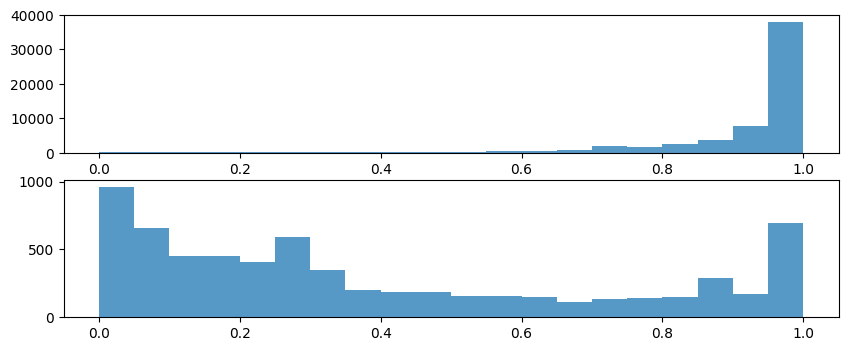

CPU times: user 35.4 s, sys: 563 ms, total: 36 s
Wall time: 35.4 s


In [7]:
%%time
# Use between 2 and 300 imports (+/- mean + std for goodware), without balancing
# Filter samples by the number of imports
dataset4 = dataset[dataset.imports.map(lambda x: len(x.split(';')) <= 300 and len(x.split(';')) > 1)]

print('Malware in dataset: {}'.format(len(dataset4[dataset4.malware == 1])))
print('Goodware in dataset: {}'.format(len(dataset4[dataset4.malware == 0])))

# Split into train and test (this also shuffles the data)
(train, test) = train_test_split(dataset4, test_size=test_size)

# Generate the count vectorizer
cv_token_pattern = u'[^;]+'
cv = CountVectorizer(token_pattern=cv_token_pattern)
train_X = cv.fit_transform(train.imports)
train_Y = train.malware
test_X = cv.transform(test.imports)
test_Y = test.malware

# Logistic Regression training
lr = LogisticRegression().fit(train_X, train_Y)

score = confusion_matrix(test_Y, lr.predict(test_X))
fp_rate, fn_rate, cc_rate, det_rate = jcfg_helpers.calc_ratios(score)
print('CC:\t{:.4f}'.format(cc_rate))
print('DR:\t{:.4f}'.format(det_rate))
print('FP:\t{:.4f}'.format(fp_rate))
print('FN:\t{:.4f}'.format(fn_rate))

malware_only = lr.predict_proba(test_X[np.where(test_Y == 1)])
goodware_only = lr.predict_proba(test_X[np.where(test_Y == 0)])
print('\nMalware stats:')
display(pd.Series(malware_only[:,1]).describe())
print('\nGoodware stats:')
display(pd.Series(goodware_only[:,0]).describe())

plt.figure(figsize=(10, 4), dpi=100)
plt.subplot(211)
plt.hist(goodware_only[:,0], bins=20, alpha=0.75)
plt.subplot(212)
plt.hist(malware_only[:,1], bins=20, alpha=0.75)
plt.show()

Malware in dataset: 13443
Goodware in dataset: 13443
CC:	0.7644
DR:	0.7719
FP:	0.2375
FN:	0.2336

Malware stats:


count    6759.000000
mean        0.713526
std         0.275928
min         0.000015
25%         0.543170
50%         0.789332
75%         0.955695
max         1.000000
dtype: float64


Goodware stats:


count    6.684000e+03
mean     7.129766e-01
std      2.966445e-01
min      3.069738e-09
25%      5.147786e-01
50%      7.976875e-01
75%      9.821498e-01
max      1.000000e+00
dtype: float64

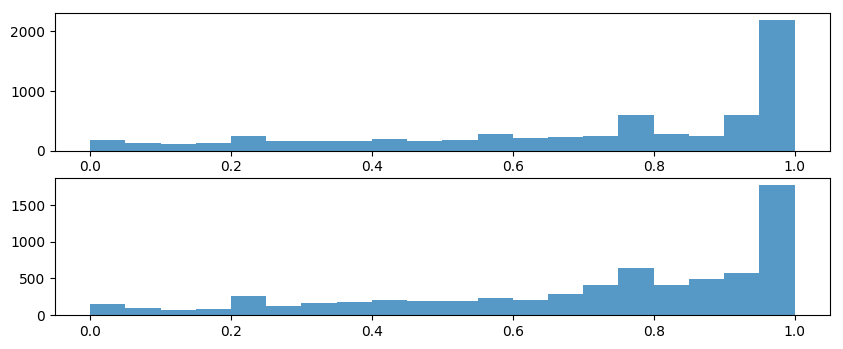

CPU times: user 5.93 s, sys: 287 ms, total: 6.22 s
Wall time: 5.88 s


In [8]:
%%time
# Use between 2 and 300 imports, balanced dataset
dataset5 = dataset[dataset.imports.map(lambda x: len(x.split(';')) <= 300 and len(x.split(';')) > 1)]
malware_count = len(dataset5[dataset5.malware == 1])
goodware_count = len(dataset5[dataset5.malware == 0])

limiting = min(malware_count, goodware_count)
malware = dataset5[dataset5.malware == 1].sample(n=limiting)
goodware = dataset5[dataset5.malware == 0].sample(n=limiting)

# Recreate the dataset, now balanced
dataset5 = pd.concat([malware, goodware])

print('Malware in dataset: {}'.format(len(dataset5[dataset5.malware == 1])))
print('Goodware in dataset: {}'.format(len(dataset5[dataset5.malware == 0])))

# Split into train and test (this also shuffles the data)
(train, test) = train_test_split(dataset5, test_size=test_size)

# Generate the count vectorizer
cv_token_pattern = u'[^;]+'
cv = CountVectorizer(token_pattern=cv_token_pattern)
train_X = cv.fit_transform(train.imports)
train_Y = train.malware
test_X = cv.transform(test.imports)
test_Y = test.malware

# Logistic Regression training
lr = LogisticRegression().fit(train_X, train_Y)

score = confusion_matrix(test_Y, lr.predict(test_X))
fp_rate, fn_rate, cc_rate, det_rate = jcfg_helpers.calc_ratios(score)
print('CC:\t{:.4f}'.format(cc_rate))
print('DR:\t{:.4f}'.format(det_rate))
print('FP:\t{:.4f}'.format(fp_rate))
print('FN:\t{:.4f}'.format(fn_rate))

malware_only = lr.predict_proba(test_X[np.where(test_Y == 1)])
goodware_only = lr.predict_proba(test_X[np.where(test_Y == 0)])
print('\nMalware stats:')
display(pd.Series(malware_only[:,1]).describe())
print('\nGoodware stats:')
display(pd.Series(goodware_only[:,0]).describe())

plt.figure(figsize=(10, 4), dpi=100)
plt.subplot(211)
plt.hist(goodware_only[:,0], bins=20, alpha=0.75)
plt.subplot(212)
plt.hist(malware_only[:,1], bins=20, alpha=0.75)
plt.show()

Malware in dataset: 13443
Goodware in dataset: 6721
CC:	0.7919
DR:	0.8766
FP:	0.1773
FN:	0.2835

Malware stats:


count    6718.000000
mean        0.809379
std         0.226133
min         0.000479
25%         0.736694
50%         0.885633
75%         0.978829
max         1.000000
dtype: float64


Goodware stats:


count    3.364000e+03
mean     6.003381e-01
std      3.399025e-01
min      1.075987e-08
25%      2.830864e-01
50%      6.116472e-01
75%      9.562759e-01
max      9.999906e-01
dtype: float64

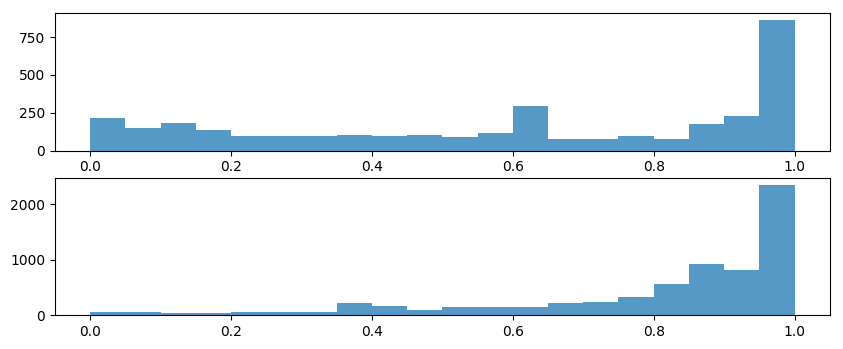

CPU times: user 5.09 s, sys: 283 ms, total: 5.37 s
Wall time: 5.03 s


In [9]:
%%time
# Use up to 300 imports, but with more malware than goodware
dataset6 = dataset[dataset.imports.map(lambda x: len(x.split(';')) <= 300 and len(x.split(';')) > 1)]
malware_count = len(dataset6[dataset6.malware == 1])
goodware_count = len(dataset6[dataset6.malware == 0])

limiting = min(malware_count, goodware_count)
malware = dataset6[dataset6.malware == 1].sample(n=limiting)
# Use 50% less goodware
goodware = dataset6[dataset6.malware == 0].sample(n=int(limiting * 0.5))

# Recreate the dataset, now balanced
dataset6 = pd.concat([malware, goodware])

print('Malware in dataset: {}'.format(len(dataset6[dataset6.malware == 1])))
print('Goodware in dataset: {}'.format(len(dataset6[dataset6.malware == 0])))

# Split into train and test (this also shuffles the data)
(train, test) = train_test_split(dataset6, test_size=test_size)

# Generate the count vectorizer
cv_token_pattern = u'[^;]+'
cv = CountVectorizer(token_pattern=cv_token_pattern)
train_X = cv.fit_transform(train.imports)
train_Y = train.malware
test_X = cv.transform(test.imports)
test_Y = test.malware

# Logistic Regression training
lr = LogisticRegression().fit(train_X, train_Y)

score = confusion_matrix(test_Y, lr.predict(test_X))
fp_rate, fn_rate, cc_rate, det_rate = jcfg_helpers.calc_ratios(score)
print('CC:\t{:.4f}'.format(cc_rate))
print('DR:\t{:.4f}'.format(det_rate))
print('FP:\t{:.4f}'.format(fp_rate))
print('FN:\t{:.4f}'.format(fn_rate))

malware_only = lr.predict_proba(test_X[np.where(test_Y == 1)])
goodware_only = lr.predict_proba(test_X[np.where(test_Y == 0)])
print('\nMalware stats:')
display(pd.Series(malware_only[:,1]).describe())
print('\nGoodware stats:')
display(pd.Series(goodware_only[:,0]).describe())

plt.figure(figsize=(10, 4), dpi=100)
plt.subplot(211)
plt.hist(goodware_only[:,0], bins=20, alpha=0.75)
plt.subplot(212)
plt.hist(malware_only[:,1], bins=20, alpha=0.75)
plt.show()